## Ecommerce Trade Sales

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Reading and Filtering data

In [3]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [4]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [5]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


### Time series plot of Ecommerce trade sales

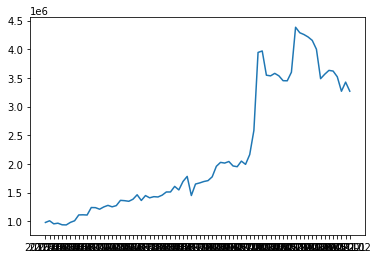

In [6]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index = retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [7]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')

In [8]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales
Date,
2016-01,977198
2016-02,1006610


**Growth Rate of Ecommerce Retail Sales**

In [9]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts[['Growth_rate']].index)
#plt.plot(retailEcommercesales_ts['Growth_rate'])
#plt.show()

In [10]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02-01,1006610,0.030098
2016-03-01,953186,-0.053073


**Time series for growth rate**

In [16]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

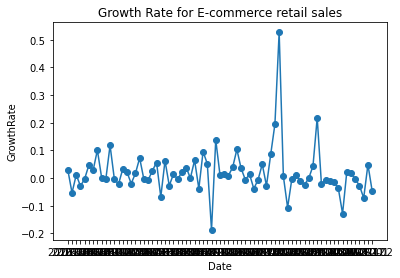

<Figure size 1600x500 with 0 Axes>

In [25]:
# Plot

plt.plot(retailEcommercesales_ts['Growth_rate'], marker = 'o')

# Labelling
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for E-commerce retail sales")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

### Stationarity Statistical test

**KPSS and ADF Test**

In [11]:
def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"
        
def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

**Testing the ecommerce sale\'s series stationarity**

In [26]:
kpss_test(retailEcommercesales_ts['Growth_rate'])
adf_test(retailEcommercesales_ts['Growth_rate'])

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


'Series is stationary'

### Keywords extraction using PyTrend

In [27]:
pytrends = TrendReq(hl = 'en-us', backoff_factor = 0.1)

def ecommerce_trend(keywords = [''],category = '340'):  #subcat - 280
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat = category
    timeframe = '2004-01-01 2022-05-11'
    geo = 'CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop = '')
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    
    return data, queries, topics

In [ ]:
data2, queries2, topics2 = ecommerce_trend(keywords = ['Doordash'],category = '340')

In [ ]:
data2.tail()

### Normalizing time series

In [12]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic

keywords_csv = pd.read_csv('../../data/keywords_data/ECOMMERCE.csv')

In [ ]:
#

In [5]:
for index, row in keywords_csv.iterrows():
    #print(([row['Keyword']]))
    data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
    
    if index==0:
        FinalData, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        FinalData.rename(columns = {'':str(row['Keyword'])}, inplace = True)    #column name for frame
        FinalData=FinalData.drop(columns=['isPartial'])   #remove column
    else:
        data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        data.rename(columns = {'':str(row['Keyword'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['Keyword'])]
        FinalData = FinalData.join(data)

NameError: name 'ecommerce_trend' is not defined

In [ ]:
FinalData

In [ ]:
FinalData

In [ ]:
FinalData.to_csv('EcommerceKeywordTimeSeries.csv')

**Dictionary of keywords**

In [ ]:
category_ts, queries, topics = ecommerce_trend(keywords = [''],category = '340')  #function calling

keyword_query_frame = dict()  #Dictionary for queries
keyword_topic_frame = dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].unique().tolist() 
keyword_top_query = queries['']['top']['query'].unique().tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].unique().tolist() 
keyword_top_topics = topics['']['top']['topic_title'].unique().tolist()

In [ ]:
# keywords dict

keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [ ]:
keyword_topic_frame

### Evaluating Category Time Series

In [ ]:
category_ts = category_ts.drop(columns = 'isPartial')
category_ts['Growth_rate'] = category_ts.pct_change()
category_ts = category_ts.dropna()

In [ ]:
category_ts.head(2)

In [ ]:
# Plot
plt.plot(category_ts['Growth_rate'], marker = 'o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for category:'E-commerce'")
plt.figure(figsize = (16,5), dpi = 100)


# Display
plt.show()

**Category Stationarity Test**

In [ ]:
kpss_test(category_ts['Growth_rate'])

In [ ]:
adf_test(category_ts['Growth_rate'])

### Keywords Time Series from CSV

In [13]:
ecommerce_keyword_ts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()


In [14]:
ecommerce_keyword_ts.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,57,0,...,0,0,53,38,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,48,45,48,0,0,0,0,0


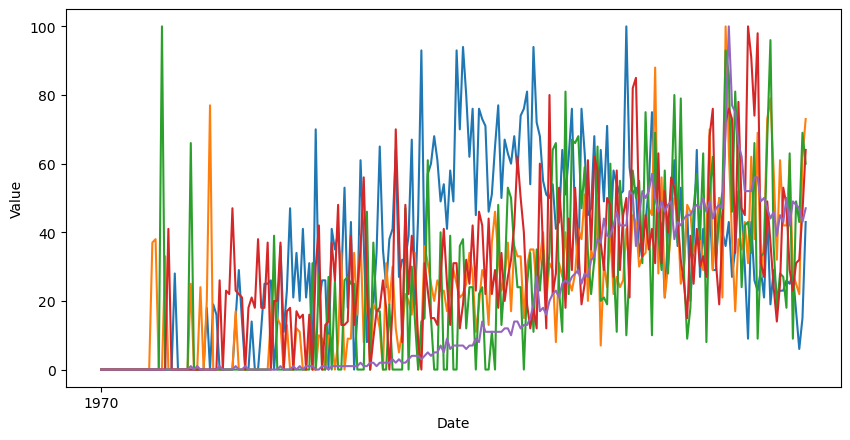

In [17]:
keywordsts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
keywordsts.index = pd.to_datetime(keywordsts.index)
plot_df(keywordsts[keywordsts.columns[10:15]], width = 10)

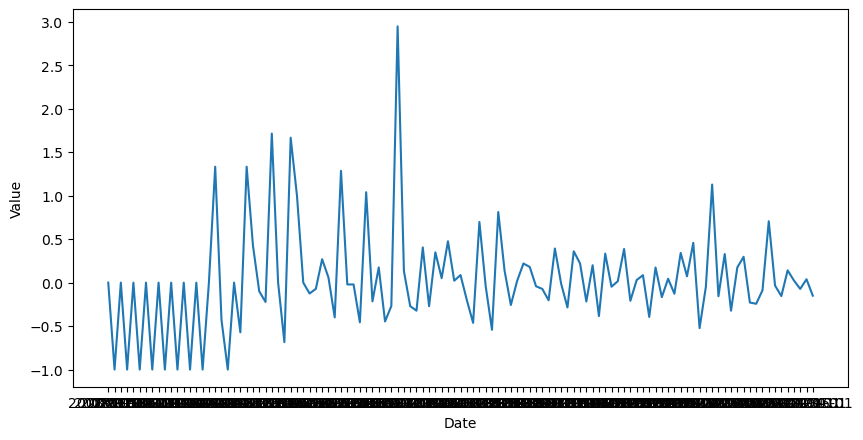

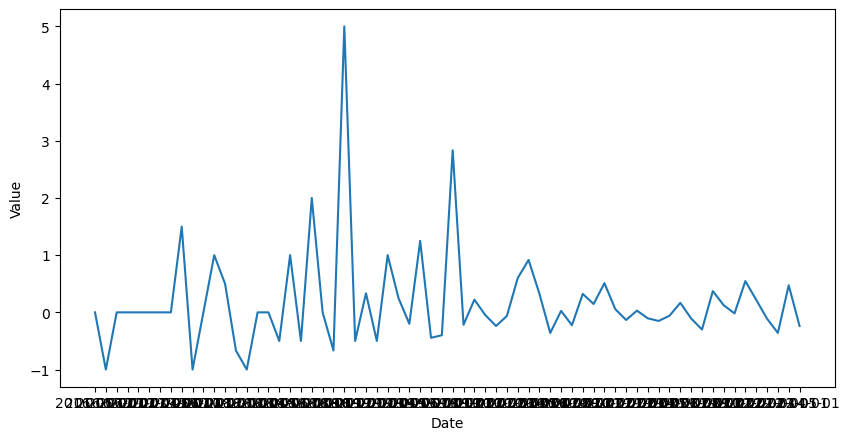

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


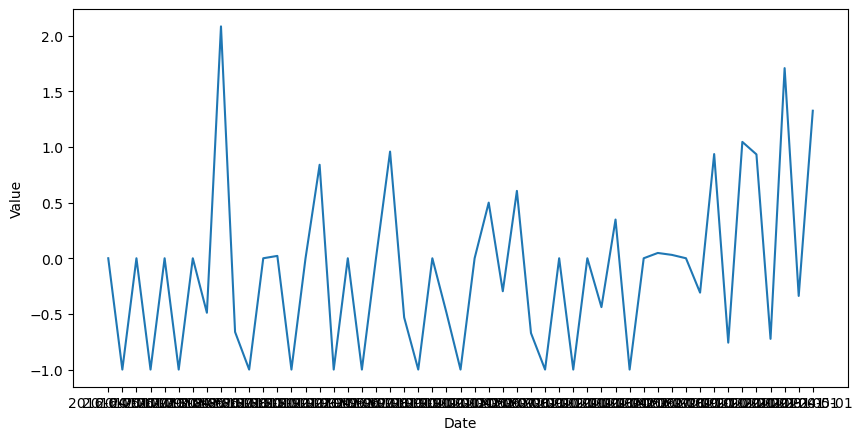

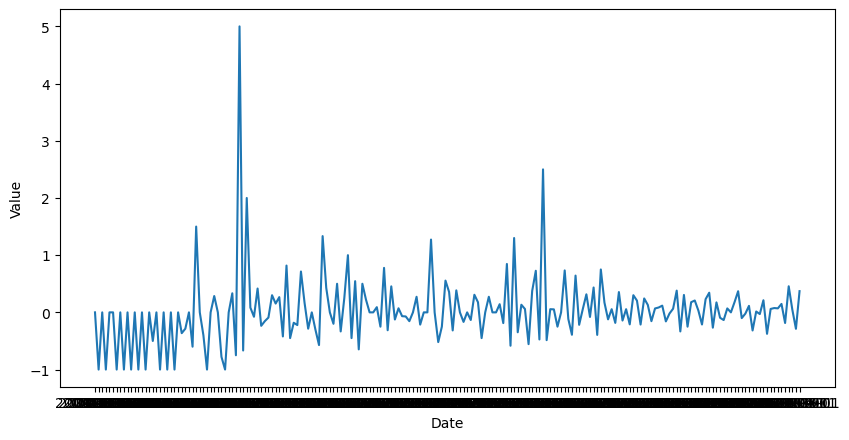

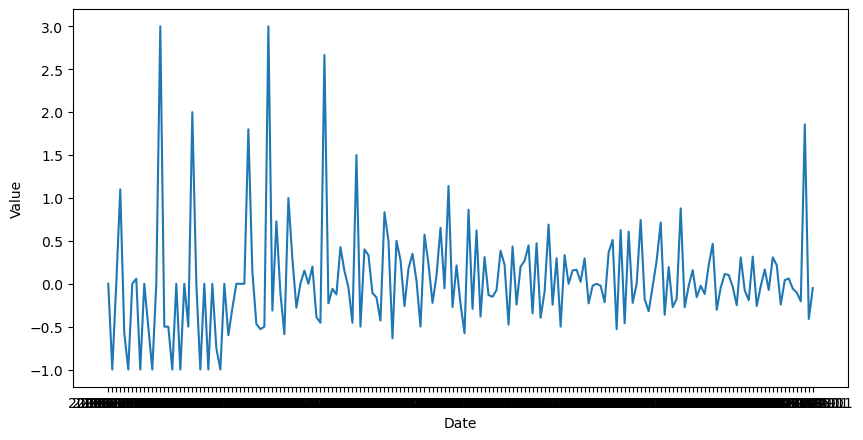

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


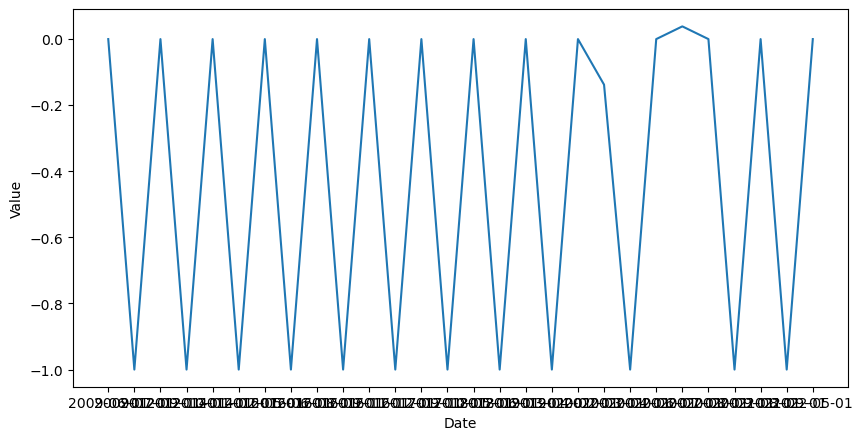

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


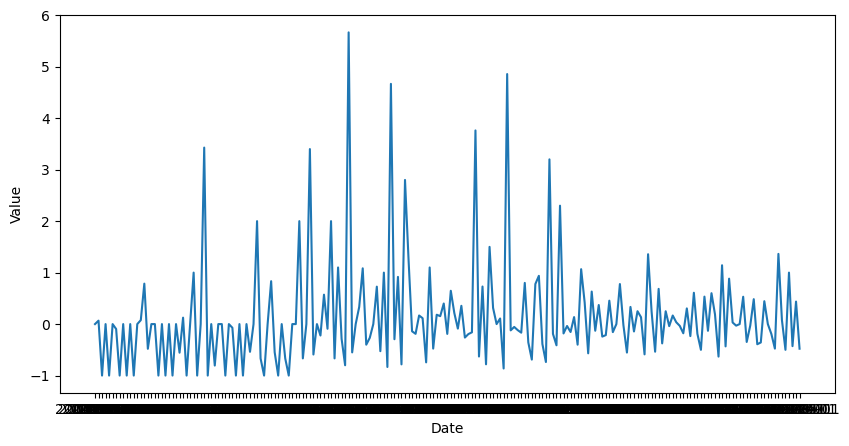

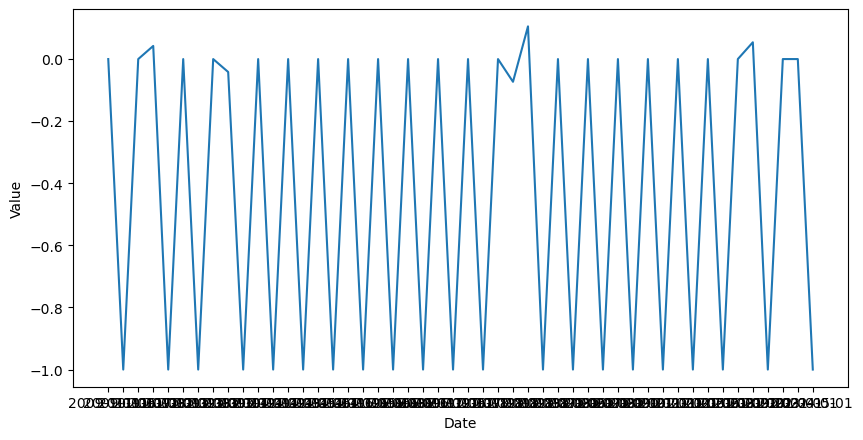

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


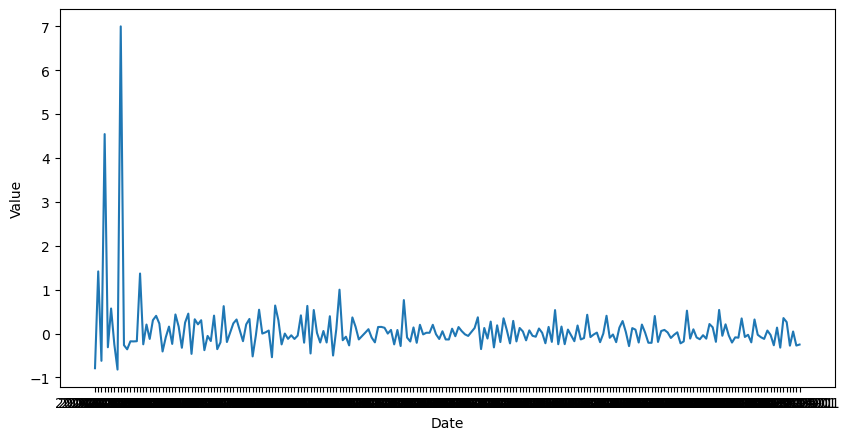

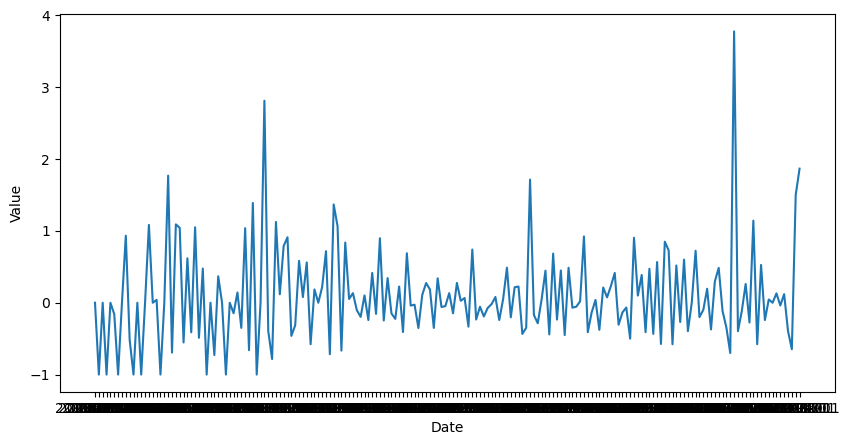

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


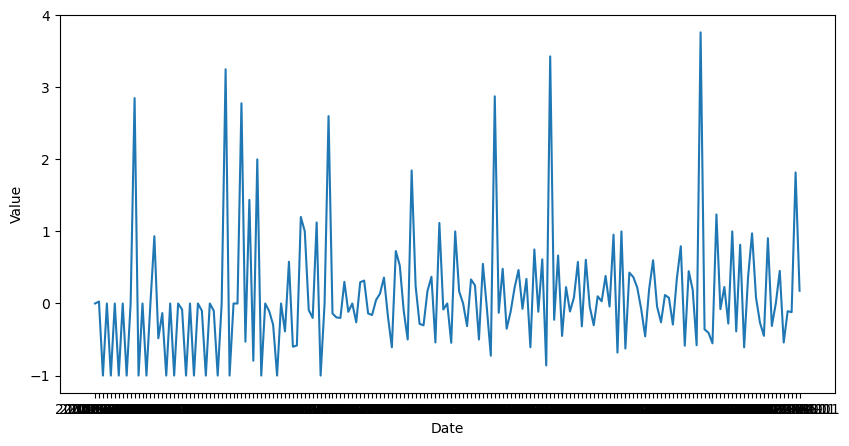

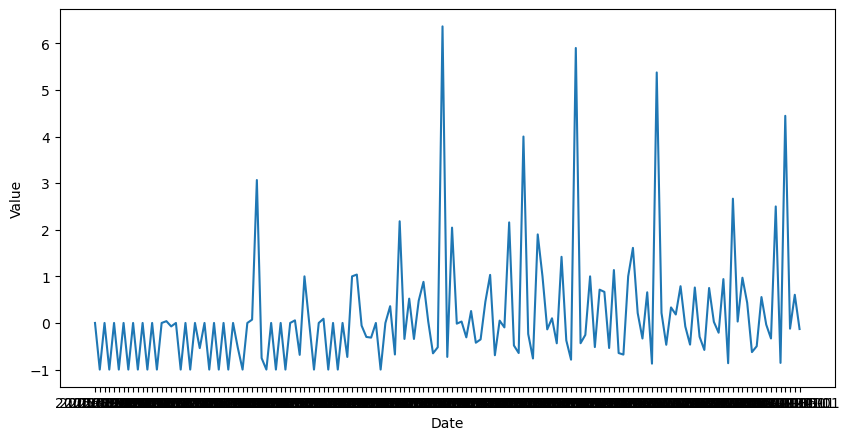

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


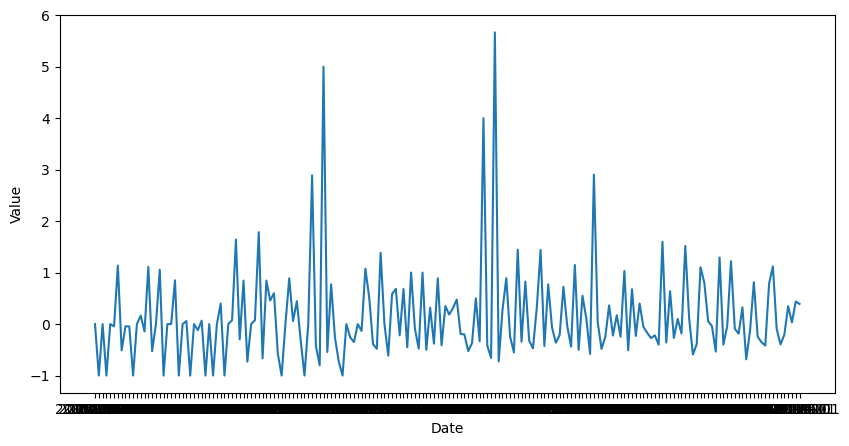

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


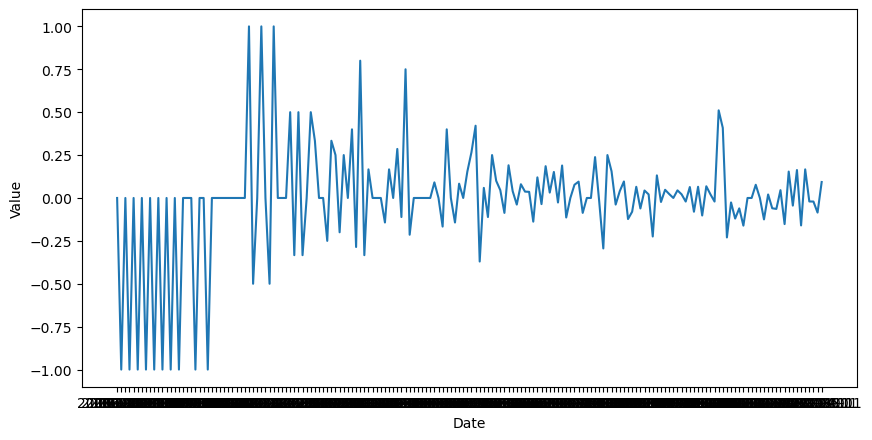

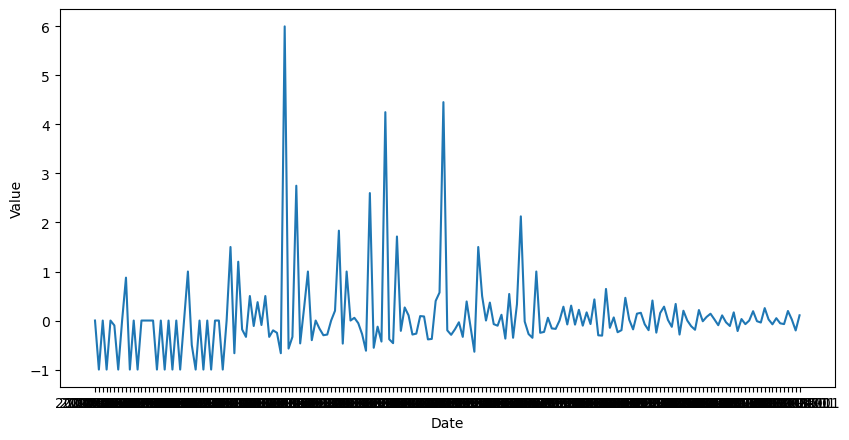

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


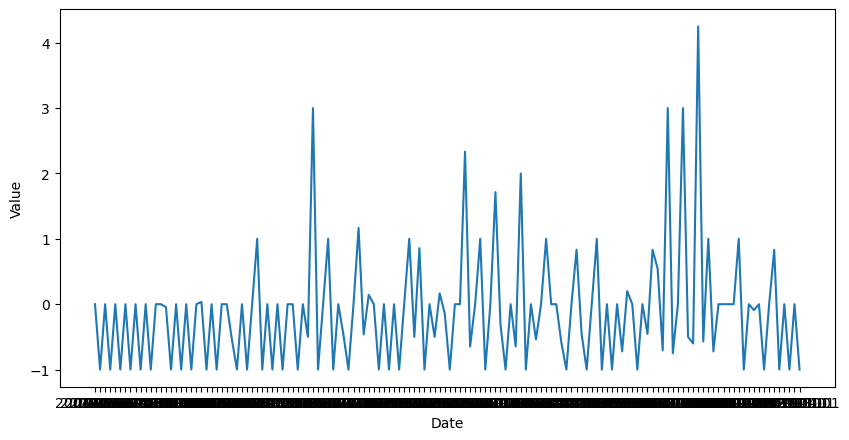

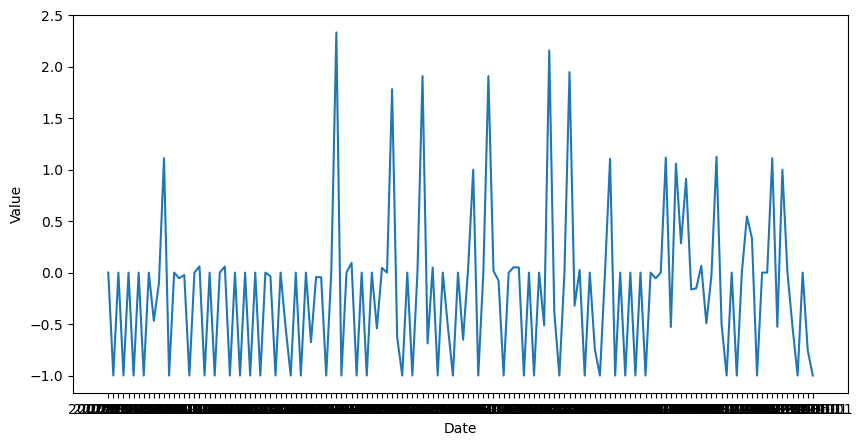

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


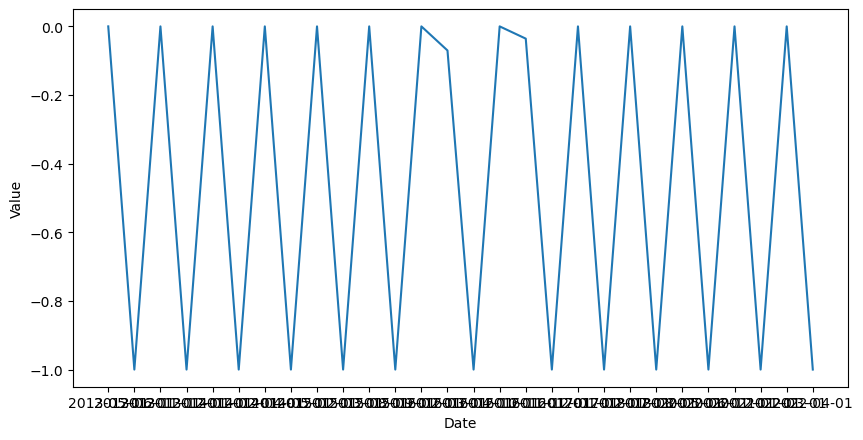

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


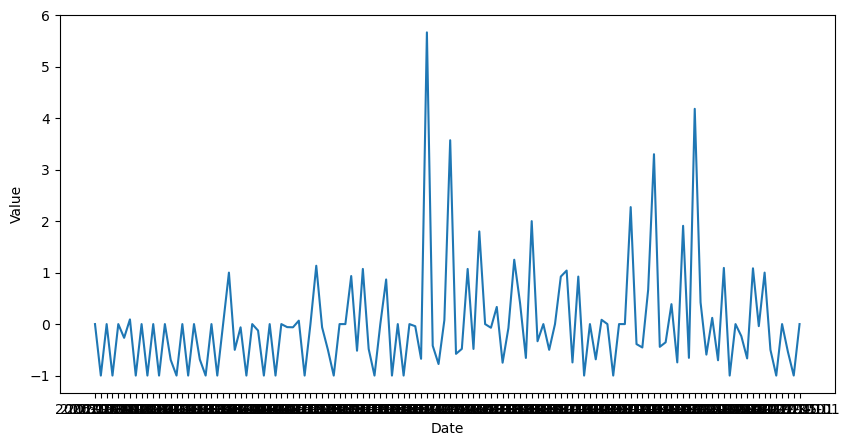

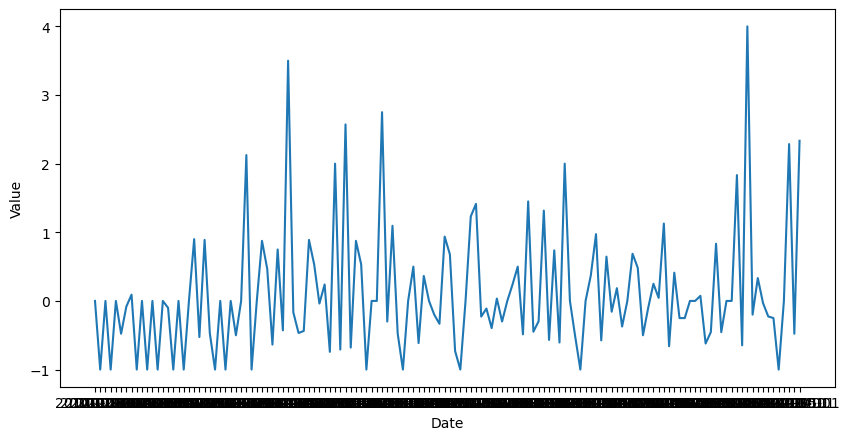

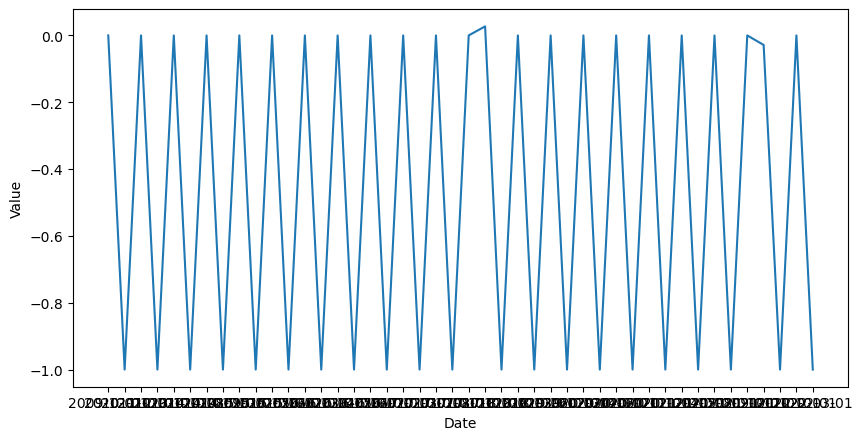

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


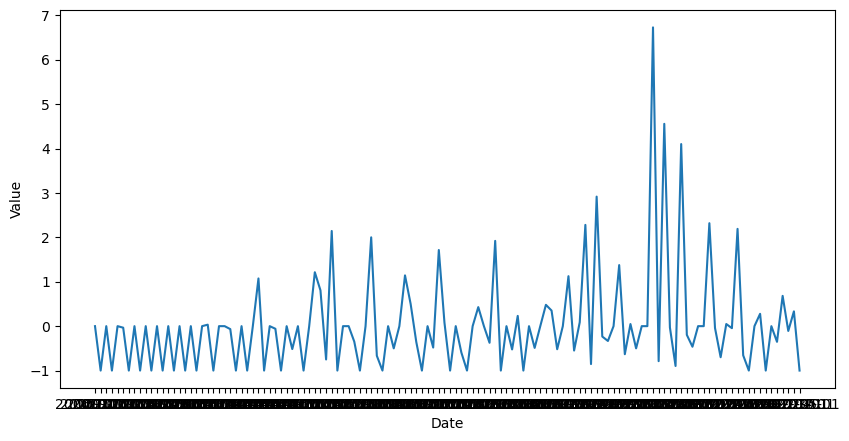

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


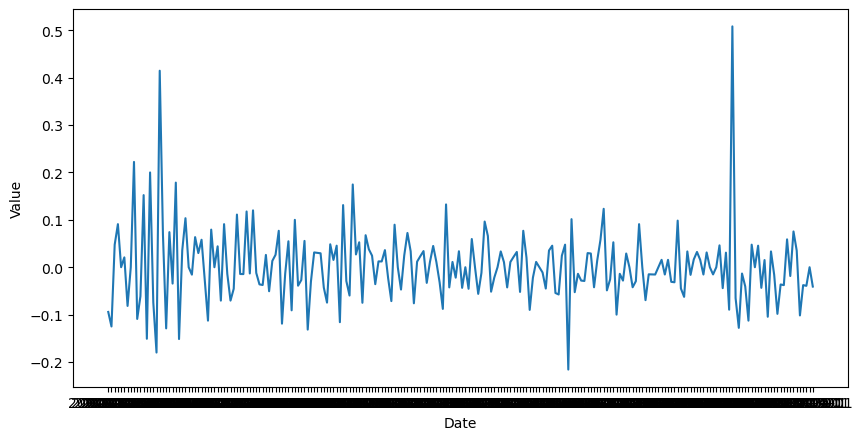

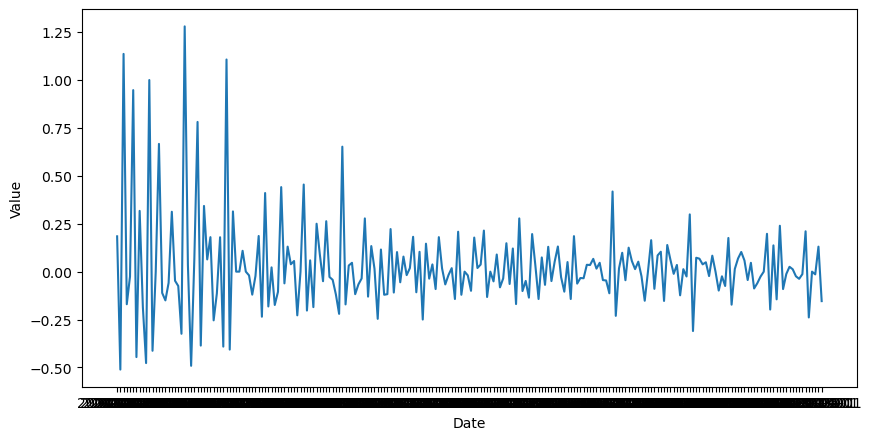

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


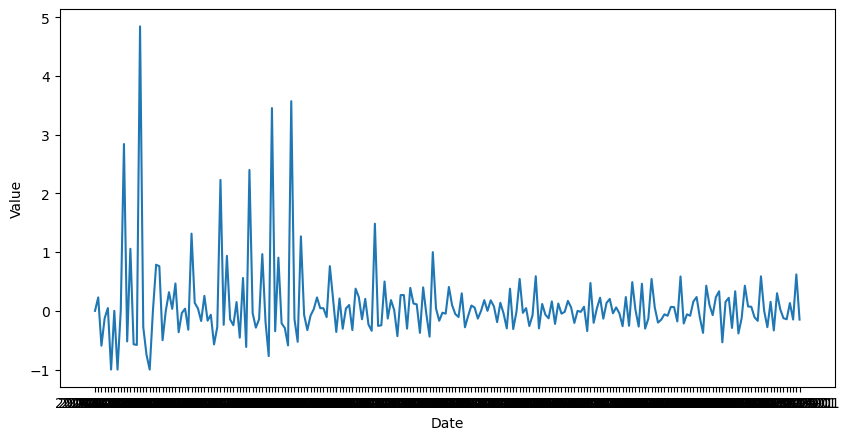

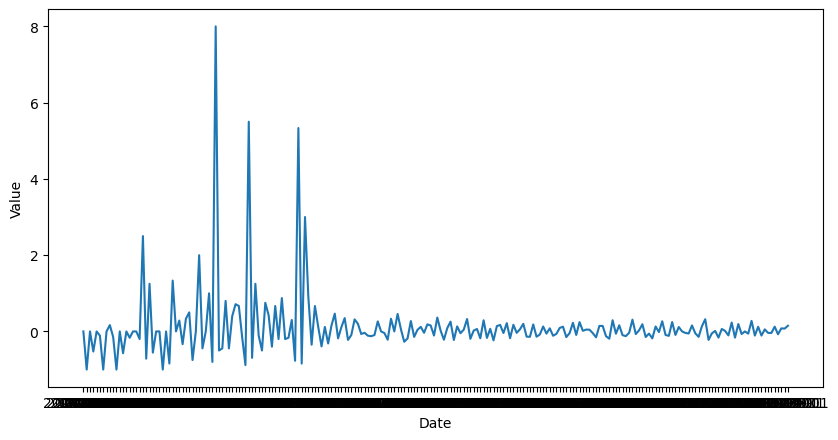

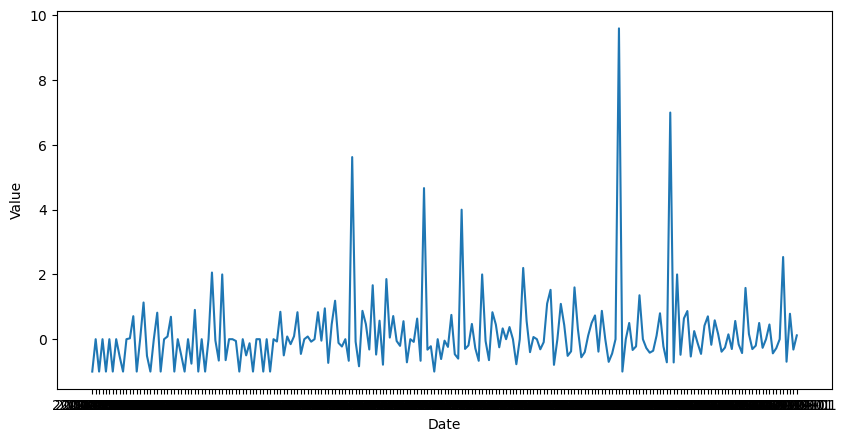

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


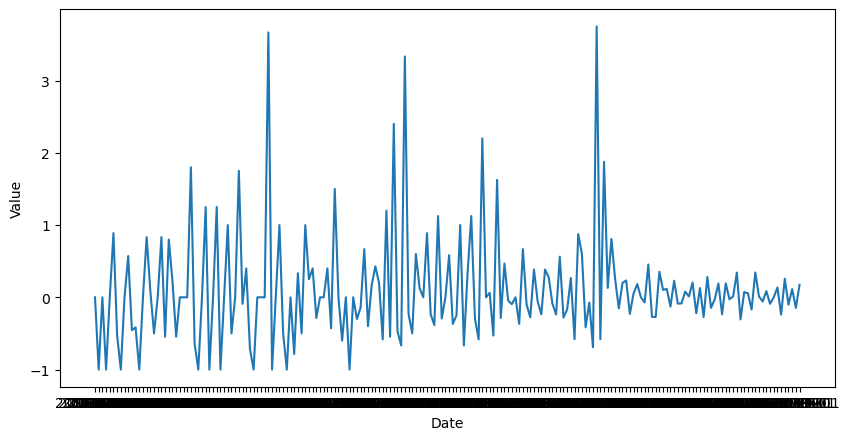

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


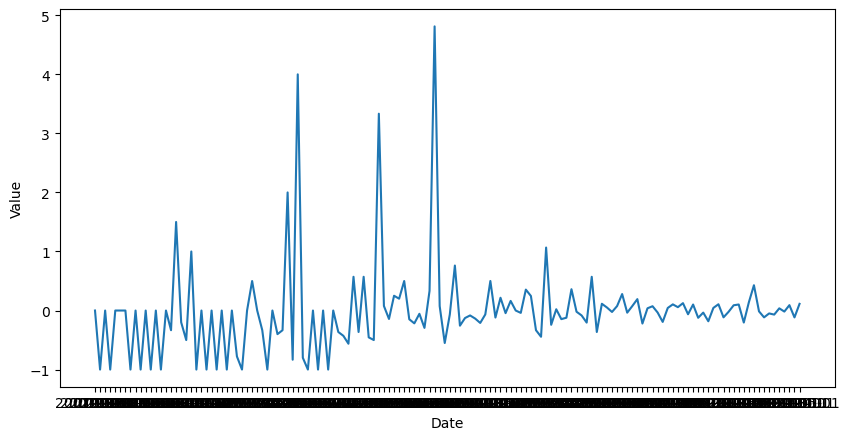

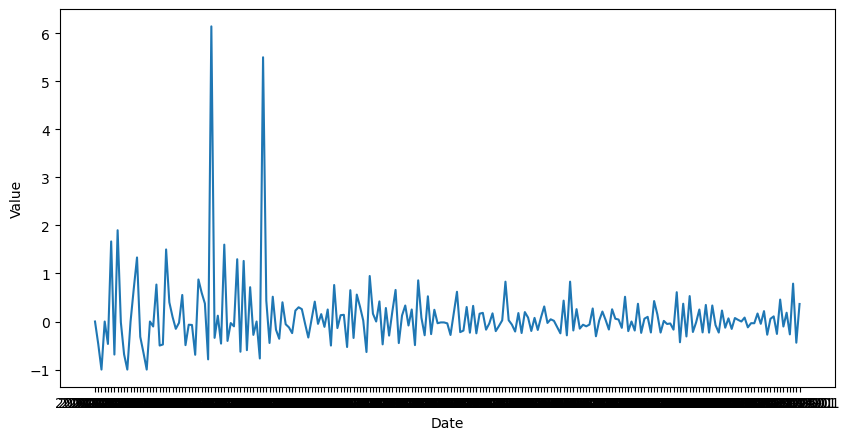

In [10]:
for column in ecommerce_keyword_ts:
    df = pd.DataFrame()
    df['Growth_rate'] = ecommerce_keyword_ts[column].pct_change()
    df = df.dropna()
    df.replace([np.inf, -np.inf], 0, inplace=True)
    plot_df(df,width=10)
    adf_test(df['Growth_rate'])
    kpss_test(df['Growth_rate'])


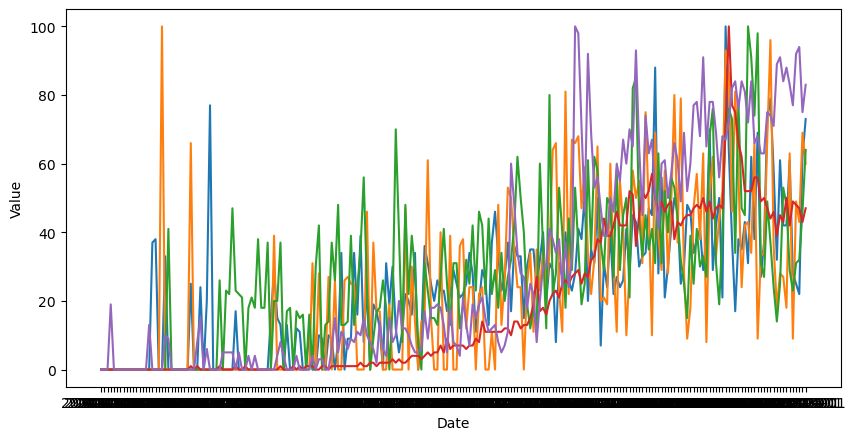

In [18]:
plot_df(ecommerce_keyword_ts[ecommerce_keyword_ts.columns[10:15]], width = 10)

In [ ]:
# get dataframe of timeseries for categories

cat_queries_dict = {}
cat_topics_dict = {}

def cat_dict():
    
    # get time series and related queries and topics of categories
    for i, category in enumerate(cat_lst):
        category = str(category)
        data, queries, topics = get_trends(category=category, related_queries=2, related_topics=2)
        cat_queries_dict[category] = queries
        cat_topics_dict[category] = topics

        #Code to append data for different columns in data frame
        if i == 0:
            data.rename(columns = {'': category}, inplace = True)
            categoryts = data.drop(columns=['isPartial'])
        else:
            data.rename(columns = {'': category}, inplace = True)
            data = data.drop(columns=['isPartial'])
            categoryts = categoryts.join(data)

# Remove the trend

### Function to extract the trend and remove it

In [19]:
def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data


In [ ]:
#transformed_data = remove_downward_trend_bias(ecommerce_keyword_ts, ecommerce_keyword_ts)

In [22]:
def make_predictors_df(*arg):
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            arg[i].index = pd.to_datetime(arg[i].index)
            arg[i+1].index = pd.to_datetime(arg[i+1].index)
            predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df

In [23]:
predictor = make_predictors_df(ecommerce_keyword_ts)
response = make_predictors_df(retailEcommercesales_ts)

# Normalize data

In [24]:
def normalize(dataframe):
    """ function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df


# difference
def detrend(dataframe):
    return dataframe.diff().dropna()


# seasonality
def remove_seasonality(dataframe):
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data


# cyclicity 
def remove_volatility(dataframe):
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

In [27]:
#temp = remove_downward_trend_bias(retailsales1, retailsales1, freq = 'M')
normalized_ecommerce_keyword = normalize(ecommerce_keyword_ts)
detrend_ecommerce_keyword = detrend(detrend(normalized_ecommerce_keyword))
#temp3 = remove_seasonality(detrend_ecommerce_keyword)
#check_stationarity(detrend_ecommerce_keyword)

In [28]:
detrend_ecommerce_keyword.head()

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-03-01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,4.095375,0.0,...,0.0,0.0,-0.074633,-1.931155,-1.854272,0.00000,10.425708,0.0,0.0,4.556124
2004-04-01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,-2.311905,0.0,...,0.0,0.0,0.597064,3.089849,-2.305312,0.00000,-11.584120,0.0,0.0,-6.685617
2004-05-01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,4.491701,0.0,...,0.0,0.0,0.149266,-2.124271,1.603695,0.00000,5.792060,0.0,0.0,-0.297139
2004-06-01,0.0,0.0,0.0,0.419241,0.000000,0.0,2.052535,0.0,-4.557756,0.0,...,0.0,0.0,-0.298532,0.450603,0.200462,0.74391,0.000000,0.0,0.0,4.655170
2004-07-01,0.0,0.0,0.0,-0.838482,1.581884,0.0,-1.915699,0.0,2.840340,0.0,...,0.0,0.0,0.074633,2.381758,-1.152656,-1.48782,0.000000,0.0,0.0,-3.268524


### Split dataset into train, test dataset

In [29]:
from sklearn.model_selection import train_test_split

def ts_train_test_split(response, predictor, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response, predictor, left_index=True, right_index=True)
    train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
    # extra test data
    extra_test_data = predictor.loc[predictor.index > joind_df.index[len(joind_df.index)-1], :]
    return train, test, extra_test_data

In [30]:
train_df, test_df, extra_df = ts_train_test_split(retailEcommercesales_ts[['Growth_rate']],temp2, 0.3)

In [31]:
predictor.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,57,0,...,0,0,53,38,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,48,45,48,0,0,0,0,0


In [32]:
response.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02-01,1006610,0.030098
2016-03-01,953186,-0.053073


In [156]:
extra_df

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-01,77,57,65,87,100,0,16,35,22,6,...,0,33,49,69,29,81,25,88,60,93
2022-04-01,80,84,43,62,59,0,23,35,16,15,...,0,44,49,78,47,87,17,75,53,52
2022-05-01,68,64,100,85,56,67,12,0,12,43,...,0,0,47,66,40,100,19,88,59,71


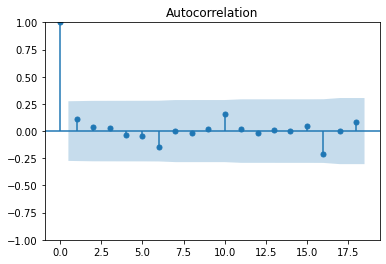

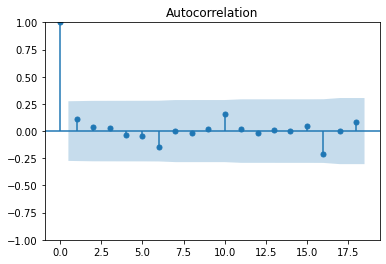

In [212]:
from statsmodels.graphics.tsaplots import *

plot_acf(train_df['Growth_rate'])

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


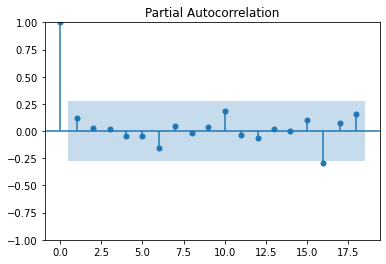

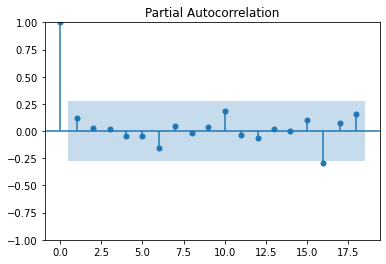

In [213]:
plot_pacf(train_df['Growth_rate'])

In [216]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(endog=train_df.Growth_rate, exog=train_df.loc[:, ~train_df.columns.isin(['Growth_rate'])], order=(4,0,4))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters foun

                               SARIMAX Results                                
Dep. Variable:            Growth_rate   No. Observations:                   51
Model:                 ARIMA(4, 0, 4)   Log Likelihood                 134.060
Date:                Wed, 18 May 2022   AIC                           -188.120
Time:                        15:43:44   BIC                           -110.847
Sample:                    02-01-2016   HQIC                          -158.591
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0205      0.019      1.107      0.268      -0.016       0.057
Uber                        -0.0048      0.024     -0.196      0.845      -0.053       0.

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


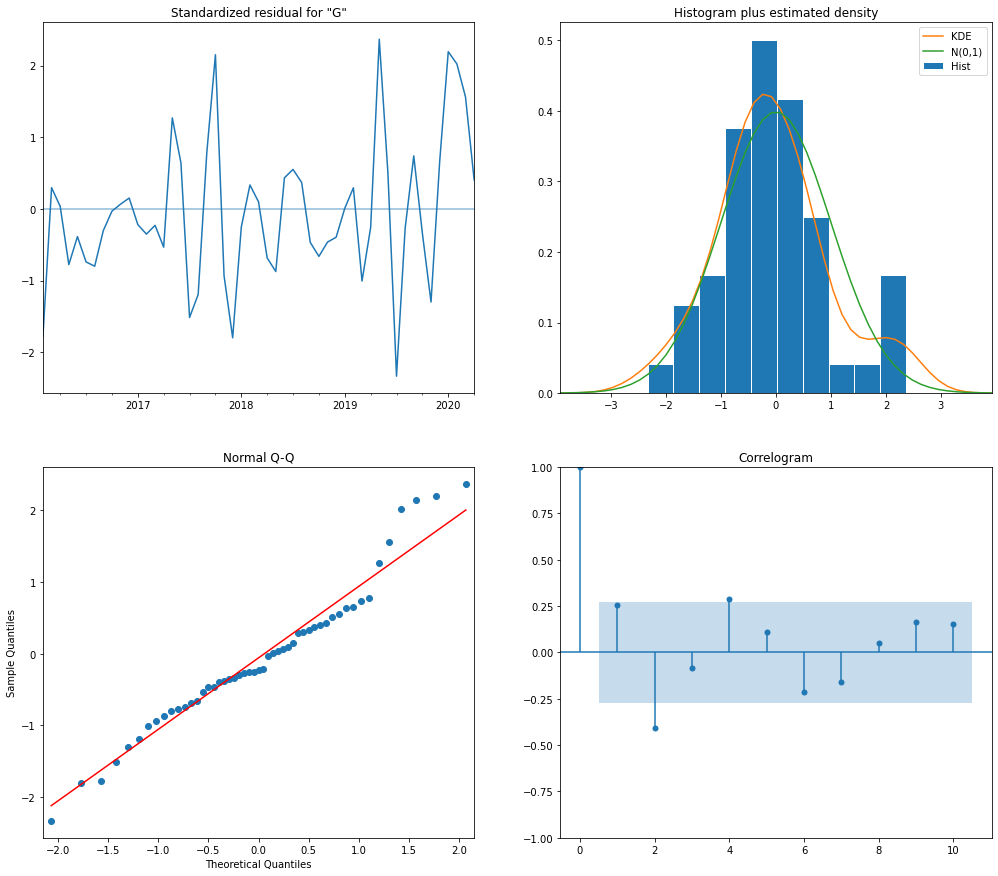

In [218]:
model_fit.plot_diagnostics(figsize=(17,15))
plt.show()

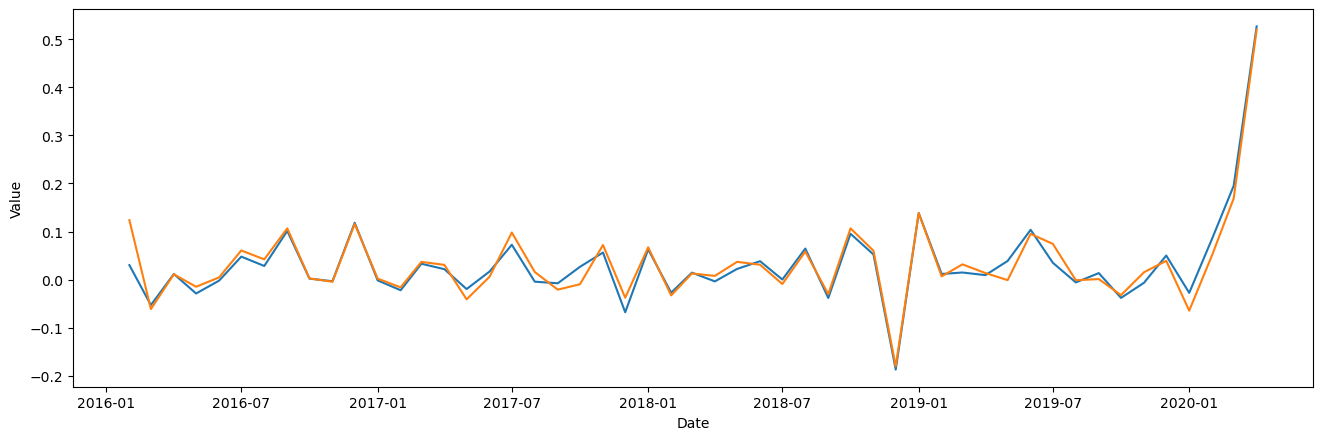

In [220]:
fitted_value = pd.DataFrame({'Original_sales' : train_df['Growth_rate'], 'Fitted_sales' : model_fit.predict()})
plot_df(fitted_value)

In [221]:
np.shape(test_df)

(22, 31)

In [225]:
test_df2 = test_df.drop(columns = 'Growth_rate')